# Correspondência entre debêntures (Anbima) e concessões do BNDES

O objetivo desse arquivo é descobrir que empresas estão ao mesmo tempo na base de debêntures da Anbima (ou seja, emitiram debêntures) e na base de operações do BNDES (ou seja, tomaram crédito com esse banco público). Assim, é possível verificar se empresas que tradicionalmente se financiavam por meio do BNDES passaram a ingressar no mercado de capitais para suprir suas necessidades de financiamento.

In [1]:
library(dplyr)
library(readxl)
library(stringr)
library(qlcMatrix)
library(ggplot2)
library(scales)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix
Loading required package: slam
Loading required package: sparsesvd


# Debêntures - Site debentures.com.br da Anbima

O primeiro passo é baixar os arquivos "características.csv" e "leasing" do site "Debentures.com.br" da Anbima. O arquivo "leasing.csv" é um arquivo acessório que contém as debêntures emitidas com a finalidade de aquisição de bens para arrendamento mercantil. O objetivo é retirar da base "caracteristicas.csv" as debêntures de leasing, porque podem não representar instrumentos propriamente ditos do mercado de capitais. Os bancos são impedidos pela legislação de emitir debêntures e utilizavam suas filiais de arrendamento mercantil para emitir esses instrumentos, com a finalidade de utilizá-los como meio de concessão de crédito para empresas.

Após a remoção das debêntures de leasing, a base de dados importada do arquivo "características.csv" passa por alguns tratamentos:

1) Como o CNPJ é importado como um número, este campo é completado com zeros à esquerda para que o CNPJ tenha 14 dígitos. É criada então a coluna "CNPJ_" com o número de 14 dígitos;

2) Uma nova coluna CNPJ_mascara é criada com a remoção dos 3 primeiros dígitos e dos 2 últimos dígitos. Isso é necessário para o confronto posterior com um arquivo de concessões do BNDES, porque esse arquivo é disponibilizado por essa instituição com uma máscara do tipo \*\*.\*00.000/0000-\*\*.

In [2]:
download.file("http://www.debentures.com.br/exploreosnd/consultaadados/emissoesdedebentures/caracteristicas_e.asp?tip_deb=publicas&op_exc=Nada&mnome=&ativo=&IPO=&icvm=&EscrituraPadronizada=&cvm_ini=&cvm_fim=&emis_ini=&emis_fim=&venc_ini=&venc_fim=&TPV=&TNV=&rent_ini=&rent_fim=&distrib_ini=&distrib_fim=&indice=&tipo=&crit_calc=&dia_ref=&mult_rend=&limite=&trat_limite=&tx_spread=&prazo=&premio_novo=&premio_prazo=&premio_antigo=&Par=&amortizacao=&mbanco=&magente=&instdep=&coordenador=&agclass=&Submit.x=25&Submit.y=8","caracteristicas.csv")
#download.file("http://www.debentures.com.br/exploreosnd/consultaadados/emissoesdedebentures/caracteristicas_e.asp?tip_deb=publicas&op_exc=Nada","caracteristicas.csv")

In [3]:
caracteristicas=read.table("caracteristicas.csv",sep="\t",fileEncoding="ISO-8859-1", quote="",skip=2,header=TRUE,stringsAsFactors=FALSE) %>%
    mutate(`Código.do.Ativo`=gsub("[[:space:]]", "", `Código.do.Ativo`))

In [4]:
nrow(caracteristicas)
colnames(caracteristicas)

[1] 4992

[1] "Código.do.Ativo"                        
 [2] "Empresa"                                
 [3] "Série"                                  
 [4] "Emissão"                                
 [5] "IPO"                                    
 [6] "Situação"                               
 [7] "ISIN"                                   
 [8] "Registro.CVM.da.Emissão"                
 [9] "Data.de.Registro.CVM.da.Emissão"        
[10] "Registro.CVM.do.Programa"               
[11] "Data.de.Registro.CVM.do.Programa"       
[12] "Data.de.Emissão"                        
[13] "Data.de.Vencimento"                     
[14] "Motivo.de.Saída"                        
[15] "Data.de.Saída...Novo.Vencimento"        
[16] "Data.do.Início.da.Rentabilidade"        
[17] "Data.do.Início.da.Distribuição"         
[18] "Data.da.Próxima.Repactuação"            
[19] "Ato.Societário..1."                     
[20] "Data.do.Ato..1."                        
[21] "Ato.Societário..2."                     
[22] "Data.do.Ato..2."                        
[23] "Forma"                                  
[24] "Garantia.Espécie"                       
[25] "Classe"                                 
[26] "Quantidade.Emitida"                     
[27] "Artigo.14º"                             
[28] "Artigo.24º"                             
[29] "Quantidade.em.Mercado"                  
[30] "Quantidade.em.Tesouraria"               
[31] "Quantidade.Resgatada"                   
[32] "Quantidade..Cancelada"                  
[33] "Quantidade.Convertida.no.SND"           
[34] "Quantidade.Convertida.fora.do.SND"      
[35] "Quantidade.Permutada.no.SND"            
[36] "Quantidade.Permutada.fora.do.SND"       
[37] "Unidade.Monetária"                      
[38] "Valor.Nominal.na.Emissão"               
[39] "Unidade.Monetária.1"                    
[40] "Valor.Nominal.Atual"                    
[41] "Data.Últ..VNA"                          
[42] "Índice"                                 
[43] "Tipo"                                   
[44] "Critério.de.Cálculo"                    
[45] "Dia.de.Referência.para.Índice.de.Preços"
[46] "Critério.para.Índice"                   
[47] "Corrige.a.cada"                         
[48] "Percentual.Multiplicador.Rentabilidade" 
[49] "Limite.da.TJLP"                         
[50] "Tipo.de.Tratamento.do.Limite.da.TJLP"   
[51] "Juros.Critério.Antigo.do.SND"           
[52] "Prêmios.Critério.Antigo.do.SND"         
[53] "Amortização...Taxa"                     
[54] "Amortização...Cada"                     
[55] "Amortização...Unidade"                  
[56] "Amortização...Carência"                 
[57] "Amortização...Critério"                 
[58] "Tipo.de.Amortização"                    
[59] "Juros.Critério.Novo...Taxa"             
[60] "Juros.Critério.Novo...Prazo"            
[61] "Juros.Critério.Novo...Cada"             
[62] "Juros.Critério.Novo...Unidade"          
[63] "Juros.Critério.Novo...Carência"         
[64] "Juros.Critério.Novo...Critério"         
[65] "Juros.Critério.Novo...Tipo"             
[66] "Prêmio.Critério.Novo...Taxa"            
[67] "Prêmio.Critério.Novo...Prazo"           
[68] "Prêmio.Critério.Novo...Cada"            
[69] "Prêmio.Critério.Novo...Unidade"         
[70] "Prêmio.Critério.Novo...Carência"        
[71] "Prêmio.Critério.Novo...Critério"        
[72] "Prêmio.Critério.Novo...Tipo"            
[73] "Participação...Taxa"                    
[74] "Participação...Cada"                    
[75] "Participação...Unidade"                 
[76] "Participação...Carência"                
[77] "Participação...Descrição"               
[78] "Rating1"                                
[79] "Agência.Classificadora"                 
[80] "Rating2"                                
[81] "Agência.Classificadora.1"               
[82] "Rating3"                                
[83] "Agência.Classificadora.2"               
[84] "Banco.Mandatário"                       
[85] "Agente.Fiduciário"                      
[86] "

In [5]:
download.file("http://www.debentures.com.br/exploreosnd/consultaadados/volume/volumepordestinacaoderecursos_e.asp?op_exc=Nada&mnome=&ativo=&mrecurso=2&mes_ini=&mes_fim=&ICVM=&moeda=1&Submit3.x=28&Submit3.y=11&totaliza=","leasing.csv")

In [6]:
leasing=read.csv("leasing.csv",sep="\t",fileEncoding="ISO-8859-1", quote="",skip=2,header=TRUE,stringsAsFactors=FALSE) %>%
    mutate(`Código.do.Ativo`=gsub("[[:space:]]", "", `Código.do.Ativo`)) %>%
        mutate(leasing="L") %>%
            select(`Código.do.Ativo`,leasing)


caracteristicas = caracteristicas %>%
    left_join(leasing,by=c("Código.do.Ativo"="Código.do.Ativo")) %>%
        filter(is.na(leasing)) %>%
            mutate(CNPJ_=str_pad(CNPJ,14,pad="0"))%>%
                mutate(CNPJ_mascara=substr(CNPJ_,4,12)) %>% 
                    mutate(`Data.de.Emissão`=as.Date(`Data.de.Emissão`,format="%d/%m/%Y"))


caracteristicas$`Percentual.Multiplicador.Rentabilidade`=as.numeric(caracteristicas$`Percentual.Multiplicador.Rentabilidade`)

caracteristicas$`Valor.Nominal.na.Emissão`=as.numeric(gsub(",",".",caracteristicas$`Valor.Nominal.na.Emissão`))

caracteristicas$Volume=caracteristicas$`Valor.Nominal.na.Emissão`*caracteristicas$Quantidade.Emitida



Warning message in eval(expr, envir, enclos):
“NAs introduzidos por coerção”

In [7]:
caracteristicas_cnpj=caracteristicas %>%            
                        group_by(Empresa,CNPJ,CNPJ_,CNPJ_mascara)  %>%
                            summarise()

caracteristicas_cnpj=data.frame(caracteristicas_cnpj)

caracteristicas_cnpj

Empresa,CNPJ,CNPJ_,CNPJ_mascara
,NA,NA,NA
ABAPORU PARTICIPACOES S/A,1.854641e+13,18546405000195,464050001
AB CONCESSOES S.A.,1.501932e+13,15019317000147,193170001
ABENGOA CONCESSOES BRASIL HOLDING S/A,7.872408e+12,07872408000100,724080001
ABIMEX IMPORTACAO E EXPORTACAO S/A,7.121351e+12,07121351000108,213510001
A BODYTECH PARTICIPACOES S.A.,7.737623e+12,07737623000190,376230001
ABRIL COMUNICACOES S/A,4.459705e+13,44597052000162,970520001
ABRIL S/A,6.059806e+13,60598059000155,980590001
ACECO TI S/A,4.320944e+13,43209436000106,094360001
ACEF S.A.,4.672283e+13,46722831000178,228310001


# BNDES - Operações contratadas na forma direta e indireta não automática 

As informações disponibilizada pelo BNDES são divididas em várias planilhas. A primeira planilha a ser considerada é a de Operações contratadas na forma direta e indireta não automática. A correspondência dessa planilha com os dados da Anbima é realizada de forma fácil, porque os dados de CNPJ são apresentados sem ocultar qualquer um dos 14 dígitos.

Como resultado dos procedimentos realizados nessa etapa, é gerado o data frame bndes_diretos, contendo as operações do BNDES referentes a empresas que também estão na base de dados da Anbima.

In [8]:
#direta e indireta não automática
diretos=read_excel("BNDES/diretos_indiretos_BASE_CONTRATAÇÕES_BNDES_TRANSPARENTE_30092019.xlsx",skip=4)

colnames(diretos)

diretos=diretos %>%
    select(Cliente,CNPJ,`Data da contratação`,`Valor contratado  R$`,`Valor desembolsado R$`,`Custo financeiro`,`Juros`,`Prazo - amortização (meses)`) %>%
        mutate(`Data da contratação`=as.Date(`Data da contratação`))
        

diretos

[1] "Cliente"                                   
 [2] "CNPJ"                                      
 [3] "Descrição do projeto"                      
 [4] "UF"                                        
 [5] "Município"                                 
 [6] "Município - código"                        
 [7] "Número do contrato"                        
 [8] "Data da contratação"                       
 [9] "Valor contratado  R$"                      
[10] "Valor desembolsado R$"                     
[11] "Fonte de recurso (desembolsos)"            
[12] "Custo financeiro"                          
[13] "Juros"                                     
[14] "Prazo - carência (meses)"                  
[15] "Prazo - amortização (meses)"               
[16] "Modalidade de apoio"                       
[17] "Forma de apoio"                            
[18] "Produto"                                   
[19] "Instrumento financeiro"                    
[20] "Inovação"                                  
[21] "Área operacional"                          
[22] "Setor CNAE"                                
[23] "Subsetor CNAE agrupado"                    
[24] "Subsetor CNAE - código"                    
[25] "Subsetor CNAE - nome"                      
[26] "Setor BNDES"                               
[27] "Subsetor BNDES"                            
[28] "Porte do cliente"                          
[29] "Natureza do cliente"                       
[30] "Instituição Financeira Credenciada"        
[31] "CNPJ da instituição financeira credenciada"
[32] "Tipo de garantia"                          
[33] "Situação do contrato"

Cliente,CNPJ,Data da contratação,Valor contratado R$,Valor desembolsado R$,Custo financeiro,Juros,Prazo - amortização (meses)
AKAER ENGENHARIA S.A.,65047250000122,2019-08-27,22200000,0,TLP,5.84,84
BETANIA LACTEOS SA,10483444000189,2019-08-26,161400,0,TLP,1.34,36
BETANIA LACTEOS SA,10483444000189,2019-08-26,424000,0,TLP,1.34,36
HERMASA NAVEGACAO DA AMAZONIA S/A,84590892000118,2019-08-09,16581916,0,US$ / CESTA,3.57,180
HERMASA NAVEGACAO DA AMAZONIA S/A,84590892000118,2019-08-09,11817340,0,US$ / CESTA,3.57,180
HERMASA NAVEGACAO DA AMAZONIA S/A,84590892000118,2019-08-09,22938359,0,US$ / CESTA,3.00,180
PREFEITURA MUNICIPAL DE SAO CAETANO DO SUL,59307595000175,2019-07-31,32144007,0,TLP,2.30,72
MUNICIPIO DE FORTALEZA,07954605000160,2019-07-30,45015682,0,TLP,1.90,228
MUNICIPIO DE FORTALEZA,07954605000160,2019-07-30,100210890,0,TLP,2.30,108
FUNDACAO PARA INOVACOES TECNOLOGICAS FITEC,01955808000195,2019-07-29,1000380,0,SEM CUSTO,0.00,0


In [9]:
bndes_diretos=diretos %>%
    inner_join(caracteristicas_cnpj,by=c("CNPJ"="CNPJ_"))

nrow(bndes_diretos)

bndes_diretos

[1] 5570

Cliente,CNPJ,Data da contratação,Valor contratado R$,Valor desembolsado R$,Custo financeiro,Juros,Prazo - amortização (meses),Empresa,CNPJ.y,CNPJ_mascara
BETANIA LACTEOS SA,10483444000189,2019-08-26,161400,0,TLP,1.3400,36,BETANIA LACTEOS S/A,1.048344e+13,834440001
BETANIA LACTEOS SA,10483444000189,2019-08-26,424000,0,TLP,1.3400,36,BETANIA LACTEOS S/A,1.048344e+13,834440001
VEREDAS TRANSMISSORA DE ELETRICIDADE S.A.,23776376000198,2019-07-11,349500000,0,TLP,1.9200,262,VEREDAS TRANSMISSORA DE ELETRICIDADE S/A,2.377638e+13,763760001
VEREDAS TRANSMISSORA DE ELETRICIDADE S.A.,23776376000198,2019-07-11,349500000,0,TLP,1.9200,262,VEREDAS TRANSMISSORA DE ELETRICIDADE S/A,2.377638e+13,763760001
AGUAS DE CAMBORIU SANEAMENTO SPE S.A.,23397533000154,2019-06-25,55384997,0,TJLP,3.3000,204,AGUAS DE CAMBORIU SANEAMENTO SPE S.A.,2.339753e+13,975330001
JOTA ELE CONSTRUCOES CIVIS S/A,77591402000132,2019-04-17,45880769,45880769,IPCA,4.3000,36,JOTA ELE CONSTRUCOES CIVIS S.A.,7.759140e+13,914020001
CUTIA EMPREENDIMENTOS EOLICOS S/A,10979076000164,2019-04-08,90507270,0,IPCA,5.8813,150,CUTIA EMPREENDIMENTOS EOLICOS S.A.,1.097908e+13,790760001
VLI MULTIMODAL S.A.,42276907000128,2019-02-21,22393474,22393474,TLP,1.6600,156,VLI MULTIMODAL S.A.,4.227691e+13,769070001
AGUAS DE SAO FRANCISCO DO SUL SPE S.A,21180700000185,2019-02-14,19771545,0,TJLP,3.3000,204,AGUAS DE SAO FRANCISCO DO SUL SPE S.A.,2.118070e+13,807000001
AGUAS DE SAO FRANCISCO DO SUL SPE S.A,21180700000185,2019-02-14,47293433,0,TJLP,3.3000,204,AGUAS DE SAO FRANCISCO DO SUL SPE S.A.,2.118070e+13,807000001


# BNDES - Operações contratadas na forma indireta automática

O segundo passo é processar um conjunto de cinco planilhas do BNDES que contêm operações contratadas na forma indireta automática. Nessas planilhas, o cnpj é apresentado com a máscara \*\*.\*00.000/0000-\*\*. Assim, algumas etapas de processamento são necessárias para realizar a correspondência com os dados da Anbima

É utilizado o campo de CNPJ com a máscara (9 dígitos explícitos e 5 dígitos faltantes) para unir as tabelas da Anbima e do BNDES. Observe que esse processo pode gerar múltiplas correspondências entre registros das duas tabelas, com o mesmo CNPJ com máscara, mas com distintos nomes de empresa. Para obter a correspondência correta entre as tabelas, deve-se utilizar também o nome da empresa. No entanto, o nome da empresa pode estar representado de forma diferente das duas bases de dado (e.g. com espaços extras, com abreviações, com sinais de pontuação diferentes e com nomes truncados). Assim, a correspondência definitiva (correspondência única correta) é obtida por meio da adoção das seguintes etapas de processamento para os nomes da empresa, na seguinte ordem:

1) Buscar empresas que possuem correspondência exata nas duas bases;

2) Troca de & por E, trocar LTDA por SA e manter apenas alfanuméricos e procurar correspondências;

3) Procurar por strings de uma tabela que contêm a string da outra tabela, no caso de nomes truncados;

6) Uso de cosseno de similaridade. A definição de um cosseno mínimo é realizada com checagem manual da base de dados.
> Definido o cosseno \>0,568 após checagem manual, com exceção de 4 registros que representam falsos positivos por meio desse critério (Ex.: BRUNET INDUSTRIA E COMERCIO DE CONFECCOES LTDA ME);

> Algumas empresas que atenderam o critério do cosseno apresentaram nomes distintos, mas por questão de mudança de razão social da empresa. Ex.:
ALUSA ENGENHARIA S.A.-> ALummi ENGENHARIA S.A.
PRINER SERVICOS INDUSTRIAIS S.A. -> Mills SERVICOS INDUSTRIAIS S.A.
ENCOMIND AGROINDUSTRIAL S/A -> Clarion AGROINDUSTRIAL S/A


Ao final, é gerado o data frame bndes_indiretos, contendo as operações do BNDES que possuem empresas correspondentes na base de dados da Anbima.

In [10]:
arquivos=list.files(path="BNDES",pattern="operacoes*")

arquivo=arquivos[1]
bndes=read_excel(paste0("BNDES/",arquivo),skip=6,na="ND") %>%
        select(Cliente,`CPF/CNPJ`,`Data da contratação`,`Valor da Operação em R$`,`Valor Desembolsado R$ (*)`,'Custo financeiro','Juros','Prazo - Amortização (meses)') %>%
            mutate(cnpj=gsub("/","",gsub("[-]","",gsub("[.]","",gsub("[*]","",`CPF/CNPJ`)))))


for (arquivo in arquivos[-1]) {
    bndes=bndes %>%
        rbind(
            read_excel(paste0("BNDES/",arquivo),skip=6,na="ND") %>%
                select(Cliente,`CPF/CNPJ`,`Data da contratação`,`Valor da Operação em R$`,`Valor Desembolsado R$ (*)`,'Custo financeiro','Juros','Prazo - Amortização (meses)') %>%
                    mutate(cnpj=gsub("/","",gsub("[-]","",gsub("[.]","",gsub("[*]","",`CPF/CNPJ`)))))    )
}

In [11]:
bndes=bndes %>%
    mutate(`Data da contratação`=as.Date(`Data da contratação`))

bndes

Cliente,CPF/CNPJ,Data da contratação,Valor da Operação em R$,Valor Desembolsado R$ (*),Custo financeiro,Juros,Prazo - Amortização (meses),cnpj
BANCO BRADESCO S.A.,**.*46.948/0001-**,2002-01-02,100000,100000,TAXA FIXA,8.75,48,469480001
CISAM SILOS E ARMAZENS LTDA,**.*45.954/0001-**,2002-01-02,3274614,3274614,TJLP,6.00,54,459540001
CONQUISTA MINUANO S/S LTDA,**.*88.096/0001-**,2002-01-02,107091,107091,TJLP,5.00,48,880960001
L. DOS S. LOIOLA,**.*42.681/0001-**,2002-01-02,20221,20221,TJLP,4.00,48,426810001
LONDRINA LIMPEZA A SECO LTDA,**.*64.413/0001-**,2002-01-02,97399,97399,TJLP,5.00,48,644130001
M M T LAVANDERIA S/S LTDA,**.*31.562/0001-**,2002-01-02,107200,107200,TJLP,5.00,48,315620001
OLIVEIRA & SOUZA COMERCIO E LAVANDERIA EPP,**.*80.909/0001-**,2002-01-02,107200,107200,TJLP,5.00,48,809090001
POUSADA MEU SOSSEGO LTDA,**.*87.564/0001-**,2002-01-02,165956,165956,TJLP,4.00,126,875640001
REPASSE SERV DE LAVANDERIA LTDA,**.*93.108/0001-**,2002-01-02,107082,107082,TJLP,5.00,48,931080001
TRANSPORTADORA JOSP LTDA.,**.*36.054/0001-**,2002-01-02,1193248,1193248,TJLP,5.00,45,360540001


In [12]:
deb_bndes=caracteristicas_cnpj %>%
    inner_join(bndes,by=c("CNPJ_mascara"="cnpj")) %>%
        group_by(Cliente,`CPF/CNPJ`,Empresa,CNPJ_mascara,CNPJ_) %>%
            summarise()

In [13]:
deb_bndes=deb_bndes %>%
    rowwise() %>%
        mutate(similaridade=sim.strings(Empresa,Cliente)) 

In [14]:
deb_bndes

Cliente,CPF/CNPJ,Empresa,CNPJ_mascara,CNPJ_,similaridade
2001 EXPRESS TRANSPORTES & SERV LTDA ME,**.*65.298/0001-**,MANGELS INDUSTRIAL S/A,652980001,61065298000102,0.15717365
3 B INDUSTRIA DE ALIMENTOS LTDA - ME,**.*73.990/0001-**,NATURA COSMETICOS S/A,739900001,71673990000177,0.21439736
3C SERVICES S A,**.*14.233/0001-**,BRASIL PCH S.A.,142330001,07314233000108,0.11180340
3D REDE DE POSTOS LTDA,**.*11.500/0001-**,GERDAU S/A,115000001,33611500000119,0.11197850
3 R 1 D TRANSPORTES LTDA ME,**.*84.319/0001-**,NORDON INDUSTRIAS METALURGICAS S/A,843190001,60884319000159,0.08126361
4S INDUSTRIA E COMERCIO DE CALCADOS LTDA,**.*01.230/0001-**,CELEO REDES TRANSMISSAO DE ENERGIA S/A,012300001,31001230000107,0.32678265
767 COMERCIO DE CEREAIS LTDA - EPP,**.*22.353/0001-**,RV TECNOLOGIA E SISTEMAS S/A,223530001,05022353000106,0.13937367
9IDEIA COMUNICACAO LTDA,**.*05.424/0001-**,AGV LOGISTICA S.A.,054240001,02905424000120,0.22496064
A A C ROCHA,**.*96.033/0001-**,NORSA REFRIGERANTES S..A...,960330001,07196033000106,0.13750477
A. A DOS SANTOS TUAN MATERIAIS DE CONSTRUCAO ME,**.*67.538/0001-**,BRAZILIAN SECURITIES CIA DE SECURITIZACAO,675380001,03767538000114,0.32791292


In [15]:
deb_bndes_=deb_bndes %>%
        mutate(Empresa_=gsub("[&]", "E", Empresa)) %>%
            mutate(Cliente_=gsub("[&]", "E", Cliente)) %>%
                mutate(Empresa_=gsub("LTDA", "SA", Empresa_)) %>%
                    mutate(Cliente_=gsub("LTDA", "SA", Cliente_)) %>%
                         filter(!(Cliente %in% 
                                        c("BRUNET INDUSTRIA E COMERCIO DE CONFECCOES LTDA ME",
                                         "BAMERINDUS S/A PARTICIPACOES - EMPREENDIMENTOS",
                                         "VECCHIO EMPORIO INDUSTRIA E COMERCIO DE ALIMENTOS LTDA",
                                            "DANPLAS INDUSTRIA E COMERCIO DE PLASTICOS LTDA EPP"))) %>%
                              mutate(Empresa_=gsub("[^[:alnum:]]", "", Empresa_)) %>%
                                    mutate(Cliente_=gsub("[^[:alnum:]]", "", Cliente_)) %>%
                                        rowwise() %>%
                                            mutate(contem=grepl(Empresa_,Cliente_)|grepl(Cliente_,Empresa_)) %>%
                                                filter(Empresa_==Cliente_|contem==TRUE|similaridade>0.568)

deb_bndes_

Cliente,CPF/CNPJ,Empresa,CNPJ_mascara,CNPJ_,similaridade,Empresa_,Cliente_,contem
ABIMEX IMPORTACAO E EXPORTACAO S/A,**.*21.351/0001-**,ABIMEX IMPORTACAO E EXPORTACAO S/A,213510001,07121351000108,1.0000000,ABIMEXIMPORTACAOEEXPORTACAOSA,ABIMEXIMPORTACAOEEXPORTACAOSA,TRUE
A! BODYTECH PARTICIPACOES S/A,**.*37.623/0001-**,A BODYTECH PARTICIPACOES S.A.,376230001,07737623000190,0.8437500,ABODYTECHPARTICIPACOESSA,ABODYTECHPARTICIPACOESSA,TRUE
ACEF S/A,**.*22.831/0001-**,ACEF S.A.,228310001,46722831000178,0.6324555,ACEFSA,ACEFSA,TRUE
ACOS VILLARES S/A.,**.*64.810/0001-**,ACOS VILLARES S/A,648100001,60664810000174,0.9271051,ACOSVILLARESSA,ACOSVILLARESSA,TRUE
ACUCAREIRA QUATA S/A,**.*55.574/0001-**,ACUCAREIRA QUATA S/A,555740001,60855574000173,1.0000000,ACUCAREIRAQUATASA,ACUCAREIRAQUATASA,TRUE
ADAMI SA MADEIRAS,**.*54.478/0001-**,ADAMI S.A. - MADEIRAS,544780001,83054478000121,0.8215838,ADAMISAMADEIRAS,ADAMISAMADEIRAS,TRUE
AGEO NORTE TERMINAIS E ARMAZENS GERAIS S.A,**.*72.637/0001-**,AGEO NORTE TERMINAIS E ARMAZENS GERAIS S/A,726370001,04272637000198,0.9682540,AGEONORTETERMINAISEARMAZENSGERAISSA,AGEONORTETERMINAISEARMAZENSGERAISSA,TRUE
AGEO TERMINAIS E ARMAZENS GERAIS S.A,**.*98.096/0001-**,AGEO TERMINAIS E ARMAZENS GERAIS S/A,980960001,03798096000173,0.9622642,AGEOTERMINAISEARMAZENSGERAISSA,AGEOTERMINAISEARMAZENSGERAISSA,TRUE
A GERADORA ALUGUEL DE MAQUINAS S.A.,**.*45.322/0001-**,A GERADORA ALUGUEL DE MAQUINAS S.A.,453220001,33845322000190,0.9534626,AGERADORAALUGUELDEMAQUINASSA,AGERADORAALUGUELDEMAQUINASSA,TRUE
AGRALE SOCIEDADE ANONIMA,**.*10.324/0001-**,AGRALE S/A,103240001,88610324000192,0.5802589,AGRALESA,AGRALESOCIEDADEANONIMA,FALSE


In [16]:
bndes_indiretos=bndes  %>%
            inner_join(deb_bndes_%>%select(`CPF/CNPJ`,Cliente,Empresa,CNPJ_), by=c("CPF/CNPJ"="CPF/CNPJ","Cliente"="Cliente"))

nrow(bndes_indiretos)

[1] 69000

# Visualização temporal de debêntures e financiamento no BNDES

In [18]:
#Criando um data frame que contenha períodos de 12 meses, em que cada linha representa um mês distinto
#a partir de 2000. O objetivo é utilizar esse data frame para acumular valores em 12 meses
inicial=as.Date("1999-12-01")

for (a in 2002:2019)
{
    
    for (m in 1:12)
    {
       
        inicial=c(inicial,as.Date(paste0(a,"-",str_pad(m,2,pad="0"),"-01")))
    }
    
}

final=(inicial-1)[14:(length(inicial)-1)]

inicial=inicial[2:(length(inicial)-13)]

datas=data.frame(inicial,final)

In [19]:
#debêntures referentes a empresas que conseguiram contrair operações de crédito com o BNDES 
#nos 2 anos anterior à emissão das debêntures
debentures_bndes_2_anos=caracteristicas %>%
    inner_join(bndes_diretos %>%
                select(CNPJ,`Data da contratação`),by=c("CNPJ_"="CNPJ")) %>%
                    mutate(diferenca=`Data.de.Emissão`-`Data da contratação`) %>%
                        filter(diferenca<365*2,diferenca>0) %>%
                            group_by(`Código.do.Ativo`) %>%
                                summarise()

debentures_bndes_2_anos = debentures_bndes_2_anos %>%
    rbind(caracteristicas %>%
        inner_join(bndes_indiretos %>% select(CNPJ_,`Data da contratação`),by=c("CNPJ_"="CNPJ_")) %>%
            mutate(diferenca=`Data.de.Emissão`-`Data da contratação`) %>%
                filter(diferenca<365*2,diferenca>0) %>%
                       group_by(`Código.do.Ativo`) %>%
                                summarise()) %>%
    group_by(`Código.do.Ativo`) %>%
                                summarise()

In [20]:
debentures_bndes_qualquer_ano=caracteristicas %>%
    inner_join(bndes_diretos %>%
                select(CNPJ,`Data da contratação`),by=c("CNPJ_"="CNPJ")) %>%
                    mutate(diferenca=`Data.de.Emissão`-`Data da contratação`) %>%
                        filter(diferenca>0) %>%
                            group_by(`Código.do.Ativo`) %>%
                                summarise()

debentures_bndes_qualquer_ano = debentures_bndes_qualquer_ano %>%
    rbind(caracteristicas %>%
        inner_join(bndes_indiretos %>% select(CNPJ_,`Data da contratação`),by=c("CNPJ_"="CNPJ_")) %>%
            mutate(diferenca=`Data.de.Emissão`-`Data da contratação`) %>%
                filter(diferenca>0) %>%
                       group_by(`Código.do.Ativo`) %>%
                                summarise()) %>%
    group_by(`Código.do.Ativo`) %>%
                                summarise()

In [21]:
caracteristicas_=caracteristicas %>%
    left_join(debentures_bndes_2_anos %>% mutate(BNDES="Operação com BNDES nos 2 anos anteriores")) %>%
        left_join(debentures_bndes_qualquer_ano %>% mutate(BNDES_qualquer="Operação com BNDES em qualquer ano anterior")) %>%
            rowwise() %>%
                mutate(BNDES=ifelse(is.na(BNDES),"Sem operação com BNDES nos 2 anos anteriores",BNDES)) %>%                  
                        mutate(BNDES_qualquer=ifelse(is.na(BNDES_qualquer),"Sem operação anterior com o BNDES",BNDES_qualquer))

caracteristicas_$BNDES=as.factor(caracteristicas_$BNDES)

Joining, by = "Código.do.Ativo"
Joining, by = "Código.do.Ativo"


In [22]:
volume=datas %>%
    mutate(dummy=TRUE) %>%
        left_join(caracteristicas_%>%mutate(dummy=TRUE),by=c("dummy"="dummy")) %>%
            filter(`Data.de.Emissão`>=inicial,`Data.de.Emissão`<=final)  %>%    
                group_by(final,BNDES) %>%
                    summarise(Volume=sum(Volume,na.rm=TRUE)) %>%
                        mutate(Data=final)

In [23]:
bndes_total=bndes_diretos %>%
    mutate(Valor=`Valor contratado  R$`) %>%
        select(`Data da contratação`,Valor) %>%
            rbind(bndes_indiretos %>%
    mutate(Valor=`Valor da Operação em R$`) %>%
        select(`Data da contratação`,Valor))

In [24]:

bndes_12meses=datas %>%
    mutate(dummy=TRUE) %>%
        left_join(bndes_total%>%mutate(dummy=TRUE),by=c("dummy"="dummy")) %>%
            filter(`Data da contratação`>=inicial,`Data da contratação`<=final) %>%
                 group_by(final) %>%
                    summarise(Volume=sum(Valor,na.rm=TRUE)) %>%
                        mutate(Data=final)

O gráfico abaixo apresenta três informações:

1)  Concessões do BNDES acumuladas em 12 meses para o grupo de empresas que também emitiram debêntures em algum momento;

2) Emissões de debêntures para empresas que realizaram operações com o BNDES nos 2 anos anteriores à data de emissão da debênture;

3) Emissões de debêntures para empresas que não realizaram operações com o BNDES nos 2 anos anteriores à data de emissão da debênture.

Verifica-se que grande parte do aumento recente do volume de emissão de debêntures é decorrente do grupo de empresas que não realizaram operações com o BNDES nos 2 anos anteriores à data de emissão da debênture.

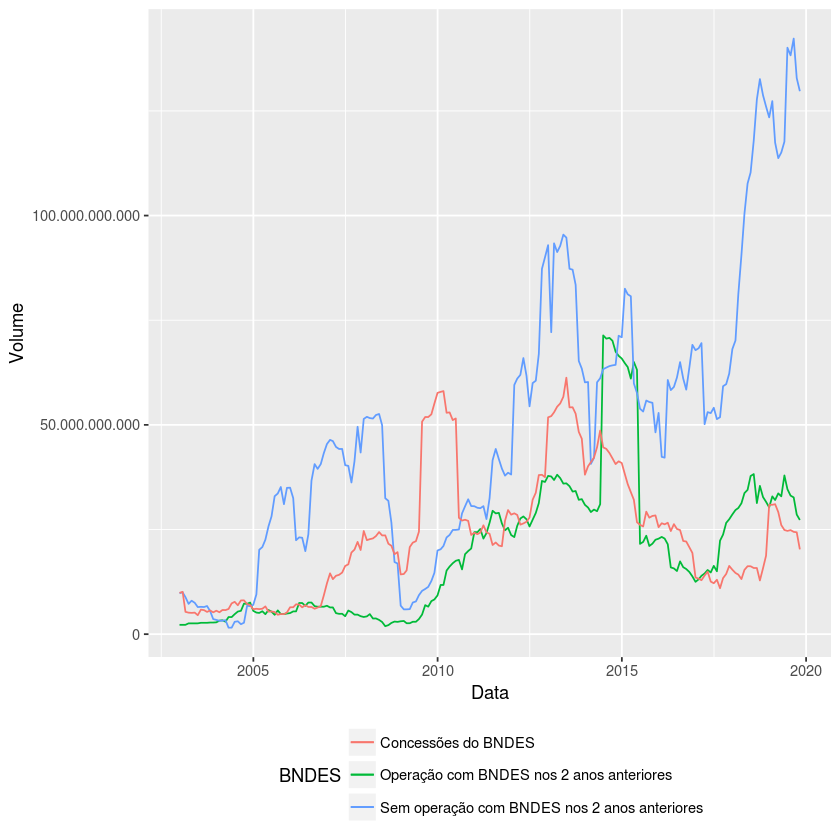

In [25]:
ggplot(volume, aes(x = Data, y = Volume,color = BNDES)) +
        geom_line() +
        geom_line(data=bndes_12meses,aes(x=Data,y=Volume,color="Concessões do BNDES"))+
            scale_y_continuous(labels = function(x) format(x, big.mark = ".",decimal.mark=",", scientific = FALSE)) +
                               theme(legend.position="bottom")+
                               guides(col=guide_legend(nrow=3,byrow=TRUE))

In [26]:
volume_qualquer=datas %>%
    mutate(dummy=TRUE) %>%
        left_join(caracteristicas_%>%mutate(dummy=TRUE),by=c("dummy"="dummy")) %>%
            filter(`Data.de.Emissão`>=inicial,`Data.de.Emissão`<=final)  %>%    
                group_by(final,BNDES_qualquer) %>%
                    summarise(Volume=sum(Volume,na.rm=TRUE)) %>%
                        mutate(Data=final)

Dentre as empresas que não fizeram operações de crédito com o BNDES nos dois anos anteriores à emissão da debênture, foram separadas as empresas que fizeram operação de crédito com o BNDES em qualquer ano anterior das empresas que nunca fizeram operação de crédito com o BNDES, conforme gráfico abaixo. Verifica-se que o aumento recente das emissões de debêntures teve grande contribuição das empresas que já realizaram operações de crédito anterior com o BNDES, mas que não tomaram crédito com esse banco público nos últmos 2 anos.

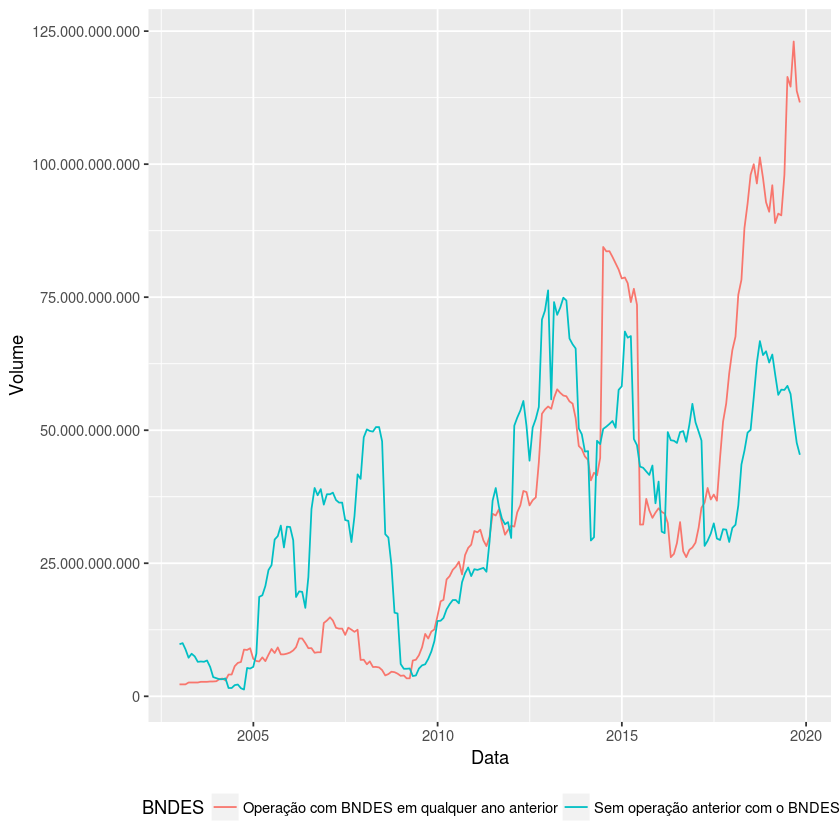

In [27]:
ggplot(volume_qualquer %>% mutate(BNDES=BNDES_qualquer), aes(x = Data, y = Volume,color = BNDES)) +
        geom_line()+
            scale_y_continuous(labels = function(x) format(x, big.mark = ".",decimal.mark=",", scientific = FALSE))  +
                               theme(legend.position="bottom")